In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis

In [2]:
model = read_sbml_model('data/iYO844_5htp.xml')

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [19]:
# Finding the flux of the phhA reaction
with model:
    print(model.reactions.DM_hydroxy_trp)
    model.objective = model.reactions.DM_hydroxy_trp
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print("HTP flux", max_5HTP_production)
    print("Biomass flux", solution.fluxes.BIOMASS_BS_10)

DM_hydroxy_trp: hydroxy_trp --> 
HTP flux 0.5776145203111496
Biomass flux 0.0


**We can see here, that when we have optimal flux towards 5-HTP production, then there will be no flux towards biomass production, thus no growth of the cell.
Let's try and optimize for both 5-HTP and biomass production**

In [20]:
# Getting the flux towards 5-HTP and biomass respectively, when optimized for both reactions
with model:
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    print("5-HTP flux", solution.objective_value)
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    print("Biomass flux", solution.objective_value)

5-HTP flux 0.2888072601555748
Biomass flux 0.05898319466120001


We can see here that the flux towards biomass and 5-HTP production are both half of their previous optimal flux, which make sense now that they share the flux

**Observing how the growth rate changes with increasing 5-HTP export flux**

In [3]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [4]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.DM_hydroxy_trp],
                    objective=model.reactions.BIOMASS_BS_10)

In [5]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,DM_hydroxy_trp
0,EX_glc__D_e,0.0,0.0,NaN,0.117966,1.255696e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.111820,1.190272e+01,NaN,0.030401
2,EX_glc__D_e,0.0,0.0,NaN,0.105674,1.124848e+01,NaN,0.060802
3,EX_glc__D_e,0.0,0.0,NaN,0.099528,1.059423e+01,NaN,0.091202
4,EX_glc__D_e,0.0,0.0,NaN,0.093381,9.939991e+00,NaN,0.121603
5,EX_glc__D_e,0.0,0.0,NaN,0.087235,9.285750e+00,NaN,0.152004
6,EX_glc__D_e,0.0,0.0,NaN,0.081089,8.631508e+00,NaN,0.182405
7,EX_glc__D_e,0.0,0.0,NaN,0.074942,7.977266e+00,NaN,0.212805
8,EX_glc__D_e,0.0,0.0,NaN,0.068796,7.323024e+00,NaN,0.243206
9,EX_glc__D_e,0.0,0.0,NaN,0.062650,6.668782e+00,NaN,0.273607


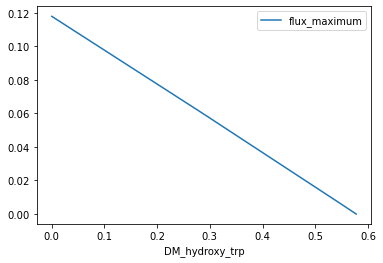

In [6]:
ppp_5HTP.plot(x='DM_hydroxy_trp', y='flux_maximum')

Not so good at all - we cannot get high flux towards 5-HTP without sacrificing the growth rate

In [7]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.DM_hydroxy_trp, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

                minimum   maximum
DM_hydroxy_trp      0.0  0.291588


If we keep the growth rate at 50% of the maximum, we still can get around 52% of the max 5-HTP flux.

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [8]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.DM_hydroxy_trp
        solution = model.optimize()
        if solution.fluxes.BIOMASS_BS_10 > 0:
            print ('5-HTP export flux:', solution.fluxes.DM_hydroxy_trp, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_BS_10)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


No solutions are displayed, as in case of every knock-out and subsequent optimisation for max 5-HTP export no growth is observed.

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [9]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.DM_hydroxy_trp > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.DM_hydroxy_trp, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In each and every case, either the growth rate or the 5-HTP export flux are very close to zero, so it can be concluded that no knock-outs would improve the 5-HTP flux

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(knock_out_list)

     Gene ID  5-HTP export flux  Biomass production flux
0   BSU24340  0.245455           3.263902e-17           
1   BSU29200  0.245455           3.263902e-17           
2   BSU22440  0.245455           3.263902e-17           
3   BSU24350  0.245455           3.263902e-17           
4   BSU29210  0.245455           3.263902e-17           
5   BSU11210  0.245455          -2.209565e-18           
6   BSU11200  0.245455          -2.209565e-18           
7   BSU16920  0.245455           2.625570e-15           
8   BSU02270  0.245455           9.472102e-18           
9   BSU00460  0.257151          -7.422270e-17           
10  BSU00500  0.257151          -4.035835e-15           
11  BSU35740  0.257151          -1.947266e-17           
12  BSU00760  0.276852           6.635196e-17           
13  BSU00740  0.235840          -1.887982e-17           
14  BSU37150  0.257151          -6.049465e-17           
15  BSU36900  0.294074           7.739983e-15           
16  BSU09540  0.257151         

<ipython-input-10-f4d78eb1eacc>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [11]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [17]:
for reaction in carbon_uptake:
    print(reaction, "with the name: ", model.reactions.get_by_id(reaction).name)


EX_2ddglcn_e with the name:  2-Dehydro-3-deoxy-D-gluconate exchange
EX_2hxmp_e with the name:  2  Hydroxymethyl phenol exchange
EX_2pg_e with the name:  D Glycerate 2 phosphate exchange
EX_2pglyc_e with the name:  2 Phosphoglycolate exchange
EX_3amba_e with the name:  3 aminobutanoic acid exchange
EX_5mtr_e with the name:  5-Methylthio-D-ribose exchange
EX_3amp_e with the name:  3'-AMP exchange
EX_6pgc_e with the name:  6 Phospho D gluconate exchange
EX_3cmp_e with the name:  3'-cmp exchange
EX_3gmp_e with the name:  3'-GMP exchange
EX_ala_L_leu__L_e with the name:  Ala Leu exchange
EX_L_alagly_e with the name:  Ala L gly exchange
EX_Larab_e with the name:  Alpha L Arabinan exchange
EX_Lcyst_e with the name:  L-Cysteate exchange
EX_abt__L_e with the name:  L Arabinitol exchange
EX_alaala_e with the name:  D-Alanyl-D-alanine exchange
EX_alltn_e with the name:  Allantoin exchange
EX_ac_e with the name:  Acetate exchange
EX_3pg_e with the name:  3 Phospho D glycerate exchange
EX_acac_e wi

In [14]:
medium = model.medium

#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    medium = model.medium
    with model:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.DM_hydroxy_trp
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_BS_10 > 0:
            print(solution.fluxes.BIOMASS_BS_10)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

In [15]:
model.medium

{'EX_fe3_e': 999999.0,
 'EX_glc__D_e': 1.7,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

**Again working under the assumption that the production of 5-HTP and biomass needs to be shared 50-50, we will try and go through the list of potential carbon sources to see which carbon source will increase the flux towards both 5-HTP and biomass production.**

In [18]:
# getting the max fluxes of 5-htp and biomass production on glucose
medium = model.medium
model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
solution = model.optimize()
glucose_max_5htp = solution.objective_value
model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
solution = model.optimize()
glucose_max_biomass = solution.objective_value
count = 0

#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    # resetting the media after each change
    medium = model.medium
    with model:
        # setting the medium to the new carbon source
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        # calculating max production of 5-htp and biomass
        model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
        solution = model.optimize()
        max_biomass_production = solution.objective_value
        # If the production is higher for both biomass and 5-htp production than using glucose as carbon source, then we print it
        if max_5HTP_production > glucose_max_5htp and max_biomass_production > glucose_max_biomass:
            count += 1
            print("optimal 5htp production using: ", model.reactions.get_by_id(reaction).name, "is ", max_5HTP_production)
            print("optimal biomass production using: ", model.reactions.get_by_id(reaction).name, "is ", max_biomass_production)
print("number of carbon sources which could improve 5-htp production: ", count)

optimal 5htp production using:  2-Dehydro-3-deoxy-D-gluconate exchange is  1.2500000000000109
optimal biomass production using:  2-Dehydro-3-deoxy-D-gluconate exchange is  0.3120924073160412


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D Glycerate 2 phosphate exchange is  0.8450413223140483
optimal biomass production using:  D Glycerate 2 phosphate exchange is  0.17741853497847876


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  3'-AMP exchange is  2.5397350993377485
optimal biomass production using:  3'-AMP exchange is  0.5348398227710915
optimal 5htp production using:  6 Phospho D gluconate exchange is  1.25
optimal biomass production using:  6 Phospho D gluconate exchange is  0.31209240731604887
optimal 5htp production using:  3'-cmp exchange is  1.848000000000004
optimal biomass production using:  3'-cmp exchange is  0.38502179539229314
optimal 5htp production using:  3'-GMP exchange is  2.4079999999999995
optimal biomass production using:  3'-GMP exchange is  0.5018626613986441


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Alpha L Arabinan exchange is  1.2499999999999942
optimal biomass production using:  Alpha L Arabinan exchange is  0.31209240731604615


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L Arabinitol exchange is  1.2499999999999918
optimal biomass production using:  L Arabinitol exchange is  0.31209240733347193
optimal 5htp production using:  D-Alanyl-D-alanine exchange is  1.6925925925925913
optimal biomass production using:  D-Alanyl-D-alanine exchange is  0.38336782876148057
optimal 5htp production using:  Allantoin exchange is  0.3233471074380174
optimal biomass production using:  Allantoin exchange is  0.06653195061692933
optimal 5htp production using:  3 Phospho D glycerate exchange is  0.8450413223140468
optimal biomass production using:  3 Phospho D glycerate exchange is  0.1774185349784779
optimal 5htp production using:  3'-UMP exchange is  1.2500000000000018
optimal biomass production using:  3'-UMP exchange is  0.32189540253535126
optimal 5htp production using:  AMP exchange is  2.539735099337746
optimal biomass production using:  AMP exchange is  0.5351826726525855
optimal 5htp production using:  4-Aminobutanoate exchange is 

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  N-Acetyl-D-mannosamine exchange is  2.500000000000047
optimal biomass production using:  N-Acetyl-D-mannosamine exchange is  0.5925717117319305
optimal 5htp production using:  N-Acetylneuraminate exchange is  3.7499999999999916
optimal biomass production using:  N-Acetylneuraminate exchange is  0.789470539997789
optimal 5htp production using:  D Arabinose exchange is  1.2499999999999383
optimal biomass production using:  D Arabinose exchange is  0.312092407316062
optimal 5htp production using:  L-Arabinose exchange is  1.2500000000000266
optimal biomass production using:  L-Arabinose exchange is  0.3120924073161072
optimal 5htp production using:  Arbutin exchange is  1.2499999999999913
optimal biomass production using:  Arbutin exchange is  0.3120924073160385
optimal 5htp production using:  L-Arginine exchange is  1.2500000000000002
optimal biomass production using:  L-Arginine exchange is  0.37115302559063384
optimal 5htp production using:  CMP exchange

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L-Asparagine exchange is  0.9055555555555544
optimal biomass production using:  L-Asparagine exchange is  0.19339705620586886
optimal 5htp production using:  L-Aspartate exchange is  0.9055555555555587
optimal biomass production using:  L-Aspartate exchange is  0.19307671395353268
optimal 5htp production using:  2-Oxoglutarate exchange is  1.195035460992912
optimal biomass production using:  2-Oxoglutarate exchange is  0.26769573383895506


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Alanine exchange is  0.8129629629629511
optimal biomass production using:  D-Alanine exchange is  0.18350782324601736


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L-Alanine exchange is  0.8129629629629651
optimal biomass production using:  L-Alanine exchange is  0.18350782324601866


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production using:  Cytidine exchange is  1.8280000000000065
optimal biomass production using:  Cytidine exchange is  0.3803492007880259
optimal 5htp production using:  D-fructose 6-phosphate exchange is  1.2499999999999925
optimal biomass production using:  D-fructose 6-phosphate exchange is  0.31209240731604365
optimal 5htp production using:  Deoxyadenosine exchange is  1.8749999999999978
optimal biomass production using:  Deoxyadenosine exchange is  0.5330383193615624
optimal 5htp production using:  Cellobiose exchange is  1.2500000000000004
optimal biomass production using:  Cellobiose exchange is  0.3120924073160406


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Deoxycytidine exchange is  1.2500000000000004
optimal biomass production using:  Deoxycytidine exchange is  0.38372252000821433


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Citrate exchange is  1.2500000000000016
optimal biomass production using:  Citrate exchange is  0.30500524378167176
optimal 5htp production using:  L-Citrulline exchange is  1.2499999999999913
optimal biomass production using:  L-Citrulline exchange is  0.3354008106344481
optimal 5htp production using:  Dextrin exchange is  1.2499999999999982
optimal biomass production using:  Dextrin exchange is  0.31209240731605437
optimal 5htp production using:  Dihydroxyacetone exchange is  1.0664605873261204
optimal biomass production using:  Dihydroxyacetone exchange is  0.2236212784624585
optimal 5htp production using:  D-Glucose exchange is  1.2500000000000009
optimal biomass production using:  D-Glucose exchange is  0.31209240731604987
optimal 5htp production using:  D Gluconate exchange is  1.2500000000000082
optimal biomass production using:  D Gluconate exchange is  0.3120924073160545
optimal 5htp production using:  D-Glucarate exchange is  1.250000000000001


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Glucuronate exchange is  1.2500000000000009
optimal biomass production using:  D-Glucuronate exchange is  0.31209240731607235
optimal 5htp production using:  L-Glutamine exchange is  1.2499999999999971
optimal biomass production using:  L-Glutamine exchange is  0.2881048943260396


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D Glutamate exchange is  1.2500000000000004
optimal biomass production using:  D Glutamate exchange is  0.30034155503883253
optimal 5htp production using:  L-Glutamate exchange is  1.2500000000000115
optimal biomass production using:  L-Glutamate exchange is  0.3003415550388417
optimal 5htp production using:  D-Fructose exchange is  1.2500000000000213
optimal biomass production using:  D-Fructose exchange is  0.31209240731604515


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Fumarate exchange is  0.9055555555555619
optimal biomass production using:  Fumarate exchange is  0.1930767139535331
optimal 5htp production using:  Deoxy D Ribose exchange is  1.250000000000006
optimal biomass production using:  Deoxy D Ribose exchange is  0.3120924073160478


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Glucose 1-phosphate exchange is  1.2499999999999956
optimal biomass production using:  D-Glucose 1-phosphate exchange is  0.3120924073160683
optimal 5htp production using:  DTMP exchange is  1.2500000000000115
optimal biomass production using:  DTMP exchange is  0.31390795565811175


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Glucose 6-phosphate exchange is  1.2500000000000024
optimal biomass production using:  D-Glucose 6-phosphate exchange is  0.31209240731606575
optimal 5htp production using:  D-Galactose exchange is  1.2500000000000289
optimal biomass production using:  D-Galactose exchange is  0.3120924073157798


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D Galactarate exchange is  1.2499999999999973
optimal biomass production using:  D Galactarate exchange is  0.2975456680368237


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Glycerol 3-phosphate exchange is  1.196551724137932
optimal biomass production using:  Glycerol 3-phosphate exchange is  0.2559631989012225
optimal 5htp production using:  Galactitol exchange is  1.2499999999999847
optimal biomass production using:  Galactitol exchange is  0.31209240731604015
optimal 5htp production using:  Glycerol exchange is  1.1446280991735571
optimal biomass production using:  Glycerol exchange is  0.23748210150765153
optimal 5htp production using:  D-Galacturonate exchange is  1.2499999999999885
optimal biomass production using:  D-Galacturonate exchange is  0.31209240731603477
optimal 5htp production using:  D-Glucosamine 6-phosphate exchange is  2.1879999999999873
optimal biomass production using:  D-Glucosamine 6-phosphate exchange is  0.4521965408437291
optimal 5htp production using:  D-Glucosamine exchange is  2.0079999999999973
optimal biomass production using:  D-Glucosamine exchange is  0.4289831660570892
optimal 5htp produ

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  GMP exchange is  2.523489932885906
optimal biomass production using:  GMP exchange is  0.5255160412559241
optimal 5htp production using:  Guanosine exchange is  2.388
optimal biomass production using:  Guanosine exchange is  0.4971898247003374


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Oxidized glutathione exchange is  2.5000000000000004
optimal biomass production using:  Oxidized glutathione exchange is  0.6174723895518548


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Reduced glutathione exchange is  1.2500000000000113
optimal biomass production using:  Reduced glutathione exchange is  0.30034155503882803
optimal 5htp production using:  Guanine exchange is  0.484259259259259
optimal biomass production using:  Guanine exchange is  0.10429009999436152


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Hypoxanthine exchange is  0.5921985815602842
optimal biomass production using:  Hypoxanthine exchange is  0.13126550972140336


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Isocitrate exchange is  1.2500000000000098
optimal biomass production using:  Isocitrate exchange is  0.3050052437816671
optimal 5htp production using:  L-Isoleucine exchange is  1.2500000000000084
optimal biomass production using:  L-Isoleucine exchange is  0.44097774859948885
optimal 5htp production using:  Myo-Inositol exchange is  1.2499999999999984
optimal biomass production using:  Myo-Inositol exchange is  0.3120924073160393
optimal 5htp production using:  Inosine exchange is  2.5066225165562916
optimal biomass production using:  Inosine exchange is  0.5247494859726316


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L-Histidine exchange is  1.2500000000000016
optimal biomass production using:  L-Histidine exchange is  0.3385976163778517
optimal 5htp production using:  D-Mannitol exchange is  1.2499999999999962
optimal biomass production using:  D-Mannitol exchange is  0.31209240731606064
optimal 5htp production using:  L-Lactate exchange is  0.8129629629629627
optimal biomass production using:  L-Lactate exchange is  0.18350782324602072


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Lactose exchange is  1.2499999999999993
optimal biomass production using:  Lactose exchange is  0.3120924073160494


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Propionate exchange is  0.8314814814814809
optimal biomass production using:  Propionate exchange is  0.18805009609858295


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Alpha Methyl D glucoside exchange is  1.2500000000000122
optimal biomass production using:  Alpha Methyl D glucoside exchange is  0.3120924073160413
optimal 5htp production using:  D-Malate exchange is  0.8314814814814803
optimal biomass production using:  D-Malate exchange is  0.18805009609875312
optimal 5htp production using:  L-Malate exchange is  0.9055555555555558
optimal biomass production using:  L-Malate exchange is  0.19307671395353204
optimal 5htp production using:  Maltose exchange is  1.250000000000019
optimal biomass production using:  Maltose exchange is  0.31209240731602345
optimal 5htp production using:  L-Proline exchange is  1.2500000000000004
optimal biomass production using:  L-Proline exchange is  0.3602970933944033


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Maltotriose exchange is  1.2500000000000095
optimal biomass production using:  Maltotriose exchange is  0.3120924073160482
optimal 5htp production using:  D O Phosphoserine exchange is  0.7018518518518547
optimal biomass production using:  D O Phosphoserine exchange is  0.15625418613027192
optimal 5htp production using:  D Mannose 1 phosphate exchange is  1.2500000000000218
optimal biomass production using:  D Mannose 1 phosphate exchange is  0.3120924073160431
optimal 5htp production using:  O-Phospho-L-serine exchange is  0.8450413223140487
optimal biomass production using:  O-Phospho-L-serine exchange is  0.17741853497847873
optimal 5htp production using:  D-Mannose 6-phosphate exchange is  1.2499999999999976
optimal biomass production using:  D-Mannose 6-phosphate exchange is  0.31209240731605187
optimal 5htp production using:  D-Mannose exchange is  1.250000000000006
optimal biomass production using:  D-Mannose exchange is  0.3120924073160439
optima

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Palatinose exchange is  1.2499999999999998
optimal biomass production using:  Palatinose exchange is  0.31209240731603893


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Phosphoenolpyruvate exchange is  0.8450413223140496
optimal biomass production using:  Phosphoenolpyruvate exchange is  0.17741853497848264
optimal 5htp production using:  Pyruvate exchange is  0.6833333333333337
optimal biomass production using:  Pyruvate exchange is  0.15171191327766606


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Raffinose exchange is  1.2500000000000095
optimal biomass production using:  Raffinose exchange is  0.3120924073160469


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Ribose exchange is  1.2500000000000013
optimal biomass production using:  D-Ribose exchange is  0.3120924073160475
optimal 5htp production using:  L Sorbose exchange is  1.2499999999999984
optimal biomass production using:  L Sorbose exchange is  0.3120924073160477


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Starch exchange is  1.25
optimal biomass production using:  Starch exchange is  0.31209240731604
optimal 5htp production using:  UMP exchange is  1.2500000000000024
optimal biomass production using:  UMP exchange is  0.3218954025340525
optimal 5htp production using:  L-Rhamnose exchange is  1.250000000000003
optimal biomass production using:  L-Rhamnose exchange is  0.3120924073162302


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Succinate exchange is  0.9981481481481493
optimal biomass production using:  Succinate exchange is  0.21639515766773065
optimal 5htp production using:  Salicin exchange is  1.249999999999993
optimal biomass production using:  Salicin exchange is  0.3120924073160568
optimal 5htp production using:  Urate exchange is  0.32334710743801637
optimal biomass production using:  Urate exchange is  0.06653195061692996
optimal 5htp production using:  D-Sorbitol exchange is  1.2499999999999982
optimal biomass production using:  D-Sorbitol exchange is  0.31209240731606064
optimal 5htp production using:  Sucrose exchange is  1.250000000000002
optimal biomass production using:  Sucrose exchange is  0.3120924073160505


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Uridine exchange is  1.2499999999999978
optimal biomass production using:  Uridine exchange is  0.32189540253534393


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Serine exchange is  0.6833333333333321
optimal biomass production using:  D-Serine exchange is  0.15171191327764666
optimal 5htp production using:  L-Valine exchange is  1.2500000000000027
optimal biomass production using:  L-Valine exchange is  0.3304111694317756
optimal 5htp production using:  L-Serine exchange is  0.7041984732824426
optimal biomass production using:  L-Serine exchange is  0.15279346346781988
optimal 5htp production using:  Xanthine exchange is  0.4657407407407401
optimal biomass production using:  Xanthine exchange is  0.0994319148972034
optimal 5htp production using:  Xanthosine exchange is  2.3680000000000034
optimal biomass production using:  Xanthosine exchange is  0.491512936537022


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  D-Xylose exchange is  1.2499999999999867
optimal biomass production using:  D-Xylose exchange is  0.3120924073160383


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  L-Threonine exchange is  0.6250000000000004
optimal biomass production using:  L-Threonine exchange is  0.22598630785566465


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production using:  Thymidine exchange is  1.2499999999999951
optimal biomass production using:  Thymidine exchange is  0.313907955658117
optimal 5htp production using:  Trehalose exchange is  1.2499999999999951
optimal biomass production using:  Trehalose exchange is  0.31209240731604143


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


number of carbon sources which could improve 5-htp production:  114


## Yield calculations

**Calculating the max theoretical yeild of 5-HTP**

In [55]:
from cobra.flux_analysis import flux_variability_analysis

In [21]:
with model:
    # calculating max yield of 5-HTP
    model.objective = model.reactions.DM_hydroxy_trp
    max_5htp_production = model.optimize().objective_value
    substrate_flux = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",max_5htp_production , "[mmol gDW^-1 h^-1]")
    # calculating molar yield
    molar_yield_5htp = max_5htp_production / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glc]")
    # Defining mass yield
    M_5htp = 0.22023 # g/mmol
    M_glc = 0.180156 # g/mmol
    mass_yield_5htp = max_5htp_production * M_5htp / (-1. * solution.fluxes['EX_glc__D_e'])*M_glc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glc]")
    

the flux of 5htp production:  0.5776145203111523 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.3397732472418543 [mmol-5htp / mmol-glc]
The mass yield of 5htp  0.013480760412122697 [g-5htp / g-glc]
The c-cmol yield of 5thp  0.02021752909902537 [cmol-5htp / cmol-glc]


In [27]:
medium = model.medium
with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 1.7
    model.medium = medium
    model.objective = model.reactions.DM_hydroxy_trp
    solution = model.optimize()
    print("the flux of 5htp production: ",solution.fluxes["DM_hydroxy_trp"] , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = solution.fluxes['DM_hydroxy_trp'] / (-1. * solution.fluxes['EX_glyc_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glyc]")
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glyc = 92.09/1000 # g/mmol
    mass_yield_5htp = solution.fluxes['DM_hydroxy_trp']* M_5htp / (-1. * solution.fluxes['EX_glyc_e'])* M_glyc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glyc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_glyc = M_glyc/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_glyc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glyc]")

the flux of 5htp production:  0.2590090090090087 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.15235824059353453 [mmol-5htp / mmol-glyc]
The mass yield of 5htp  0.0030899745369634304 [g-5htp / g-glyc]
The c-cmol yield of 5thp  0.004737642928148733 [cmol-5htp / cmol-glyc]


**Calculating yield at 50% growth**

In [24]:
# Calculating the yield of 5-HTP and biomass on glucose carbon source
medium = model.medium

with model:
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    glucose_max_5htp = solution.objective_value
    substrate_flux = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",glucose_max_5htp, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = glucose_max_5htp / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    # defining mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glc = 180.156/1000 # g/mmol
    glucose_mass_yield_5htp = glucose_max_5htp*M_5htp / (-1. * substrate_flux)*M_glc
    print("The mass yield of 5htp ", glucose_mass_yield_5htp , "[g-5htp / g-Sub]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = glucose_mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    glucose_max_biomass = solution.objective_value
    print("the flux of biomass production: ",glucose_max_biomass, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = glucose_max_biomass / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    glucose_mass_yield_biomass = glucose_max_biomass*M_biomass / (-1. * substrate_flux)*M_glc
    print("The mass yield of biomass ", glucose_mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = glucose_mass_yield_biomass * (cmol_glc / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.2888072601555745 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.16988662362092619 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.0067403802060613085 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.010108764549512626 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.058983194661199466 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.0346959968595291 [mmol-X / mmol-Sub]
The mass yield of biomass  0.00015376702345154297 [g-X / g-Sub]
The c-cmol yield of biomass  0.00018768327829902557 [cmol-X / cmol-Sub]


**Replace glucose with glycerol**

In [29]:
medium = model.medium

with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 1.7
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_glyc_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_sub = 92.09/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_sub = M_sub/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.1295045045045031 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.07617912029676653 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.0015449872684817002 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.0023688214640743433 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.02656657750328796 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.01562739853134586 [mmol-X / mmol-Sub]
The mass yield of biomass  3.540252741649035e-05 [g-X / g-Sub]
The c-cmol yield of biomass  4.417640582363951e-05 [cmol-X / cmol-Sub]


**Replace glucose with sucrose**

In [28]:
medium = model.medium

with model:
    #replace glucose with sucrose
    medium['EX_glc__D_e'] = 0
    medium["EX_sucr_e"] = 1.7
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_sucr_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of sucrose
    M_sub = 342.29/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # sucrose: C12H22O11 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.6488000000000002 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.3816470588235295 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.02876951960174119 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.04098847701239611 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.13465974630198455 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.07921161547175562 [mmol-X / mmol-Sub]
The mass yield of biomass  0.00066698825895175 [g-X / g-Sub]
The c-cmol yield of biomass  0.0007733855391483554 [cmol-X / cmol-Sub]


**Replace glucose with lactose**

In [30]:
medium = model.medium

with model:
    #replace glucose with lactose
    medium['EX_glc__D_e'] = 0
    medium["EX_lcts_e"] = 1.7
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_lcts_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of lactose
    M_sub = 342.3/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # lactose: C12H22O11 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.6477797513321562 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.3810469125483272 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.028725118238742343 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.04092641318331462 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.1315065566502862 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.07735679802958012 [mmol-X / mmol-Sub]
The mass yield of biomass  0.0006513891063519218 [g-X / g-Sub]
The c-cmol yield of biomass  0.0007553200918166084 [cmol-X / cmol-Sub]


**Replace glucose with galactose**

In [31]:
medium = model.medium

with model:
    #replace glucose with lactose
    medium['EX_glc__D_e'] = 0
    medium["EX_gal_e"] = 1.7
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_gal_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of galactose
    M_sub = 180.16/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # galactose: C6H12O6 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.28769982238010666 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.16923518963535686 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.006714683152941178 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.005035224721568628 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.058194897248275985 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.03423229249898588 [mmol-X / mmol-Sub]
The mass yield of biomass  0.00015171532948878545 [g-X / g-Sub]
The c-cmol yield of biomass  9.259157778014764e-05 [cmol-X / cmol-Sub]


**Replace glucose with Fructose**

In [32]:
medium = model.medium

with model:
    #replace glucose with fructose
    medium['EX_glc__D_e'] = 0
    medium["EX_fru_e"] = 1.7
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.DM_hydroxy_trp: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_fru_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of fructose
    M_sub = 180.16/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # fructose: C6H12O6 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_BS_10: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  0.27685950413223176 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.16285853184248927 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.0064616788176956805 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.004845501147950094 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.058769889711620615 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.03457052335977683 [mmol-X / mmol-Sub]
The mass yield of biomass  0.0001532143470170359 [g-X / g-Sub]
The c-cmol yield of biomass  9.350642533397419e-05 [cmol-X / cmol-Sub]
